# Example: How to solve an ODE with a neural network
[source](https://towardsdatascience.com/how-to-solve-an-ode-with-a-neural-network-917d11918932)

## Implement the network
In total, the network has 31 trainable parameters:
* the weights and biases for the hidden layer,
* plus the weights and bias for the output layer.

![net](img/net.webp)

In [1]:
import jax.numpy as np

# activation function
def sigmoid(x):
    return 1./(1. + np.exp(-x))

# net
def f(params, x):
    "Note that f has two arguments:\
        * an array of network parameters (params),\
        * and an input value (x). "
    w0 = params[:10]
    b0 = params[10:20]
    w1 = params[20:30]
    b1 = params[30]
    x = sigmoid(x*w0 + b0)
    x = sigmoid(np.sum(x*w1) + b1)
    return x

## Initialization of network params

In [2]:
from jax import random

key = random.PRNGKey(0) # pseudo-random number generator
                        # By creating a PRNG key with a certain seed
                        # we ensure that our results will be reproducible.
params = random.normal(key, shape=(31,))

In [3]:
from jax import grad

dfdx = grad(f, 1) # derivative of wrt x (1 means deriving x wrt the 2nd entry)

## ODE

$$
\begin{equation}
    \begin{cases}
        y' = 2xy\\
        y(0) = 1
    \end{cases}\,.
\end{equation}
$$

In [4]:
inputs = np.linspace(-2., 2., num=401) # domain of the ode

In [23]:
# Vectorize f using vmap because of differentiation purposes
# in fact JAX requires a scalar function, so we must pass a single value as input
# in order to get a single value as output

from jax import vmap

f_vect = vmap(f, (None, 0))
dfdx_vect = vmap(dfdx, (None, 0)) # each function is to be mapped over the 0-axis of the second argument (x),
                                  # while the first argument (params) should be left untouched

In [34]:
import jax.numpy as jnp

vv = lambda x, y: jnp.vdot(x, y)  #  ([a], [a]) -> []
mv = vmap(vv, (0, None), 0)      #  ([b,a], [a]) -> [b]      (b is the mapped axis)
mm = vmap(mv, (None, 1), 1)      #  ([b,a], [a,c]) -> [b,c]  (c is the mapped axis)

In [6]:
# Loss function: it contains the ode to solve

from jax import jit # just-in-time compilation (to accelerate computations we use GPU)

@jit
def loss(params, inputs):
    eq = dfdx_vect(params, inputs) + 2.*inputs*f_vect(params, inputs) # y' + 2xy
    ic = f(params, 0.) - 1.
    return np.mean(eq**2) + ic**2

In [7]:
# differentiate the loss function with respect to the trainable parameters:

grad_loss = jit(grad(loss, 0)) # grad wrt 0=first entry, i.e. params

## Training process

To accelerate things a bit, we will use gradient descent with **Nesterov momentum**.
![title](img/nestorov.webp)

In [8]:
epochs = 1000
learning_rate = 0.1
momentum = 0.99
velocity = 0.

for epoch in range(epochs):
    if epoch % 100 == 0:
        print('epoch: %3d loss: %.6f' % (epoch, loss(params, inputs)))
    gradient = grad_loss(params + momentum*velocity, inputs)
    velocity = momentum*velocity - learning_rate*gradient
    params += velocity

epoch:   0 loss: 0.954726
epoch: 100 loss: 0.061131
epoch: 200 loss: 0.024128
epoch: 300 loss: 0.008868
epoch: 400 loss: 0.003202
epoch: 500 loss: 0.001567
epoch: 600 loss: 0.000880
epoch: 700 loss: 0.000505
epoch: 800 loss: 0.000306
epoch: 900 loss: 0.000224


## Result and plot

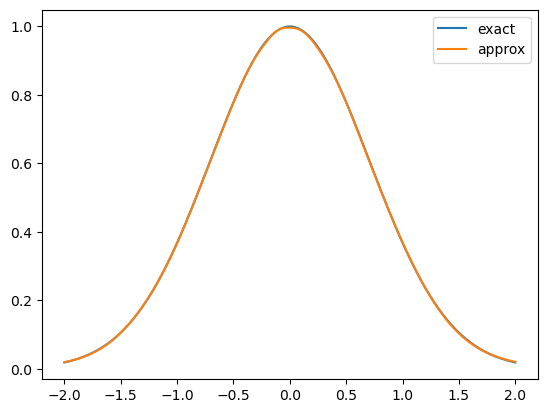

In [9]:
import matplotlib.pyplot as plt

plt.plot(inputs, np.exp(-inputs**2), label='exact')
plt.plot(inputs, f_vect(params, inputs), label='approx')
plt.legend()
plt.show()